In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

import time

from IPython.display import display
from pathlib import Path

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# Do we find GPU?
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Are we using GPU`?
tf.test.is_built_with_cuda()

True

In [4]:
# need to specify class labels, copied from training phase
class_names = ['death', 'non-death']

# Load trained model
models_file_path = Path() / 'models'
model_file = models_file_path / 'theModel'

model = tf.keras.models.load_model(model_file)

In [5]:
# Need to preprocess images the same way as we did during training
# resizing them first
frame_size_ratio = 1/4
frame_size = tuple((frame_size_ratio * np.array([1920, 1080])).astype(int))

frame_size

(480, 270)

In [6]:
# define cropped region shape (same as training input size)
# NOTE numpy format: y, x, n_channels  -- i.e. height, width, 3 (from rgb)
cropped_shape = 54, 125, 3
print(f'cropped images should have shape {cropped_shape}')

cropped images should have shape (54, 125, 3)


In [7]:
def resize_frame(frame):
    return np.array(PIL.Image.fromarray(frame).resize(frame_size))

In [8]:
def get_cropped_bounds():
    x, y = frame_size

    x_margin = 0.37
    y_margin = 0.40
    x_offset = 0
    y_offset = 0.01

    x_min = int(x * (x_margin + x_offset))
    x_max = int(x * ((1 - x_margin) + x_offset))
    y_min = int(y * (y_margin + y_offset))
    y_max = int(y * ((1 - y_margin) + y_offset))
    
    return y_min, y_max, x_min,x_max

cy_min, cy_max, cx_min, cx_max = get_cropped_bounds()

In [9]:
# after screenshot is resized, we extract cropped region
def get_death_text_crop(im, debug=False):
    
    cropped = im[cy_min: cy_max, cx_min:cx_max, :]
    
    if debug:
        display(f'Image shape {im.shape} cropped to region x:{cx_min, cx_max} y:{cy_min, cy_max} with shape {cropped.shape}')

    return cropped

In [10]:
def preprocess_captured_frame(img_array):
    img_array = resize_frame(img_array)
    img_array = get_death_text_crop(img_array)
    return img_array

In [11]:
def classify_image_array(img_array, print_image=False):
    img_array_batch = tf.expand_dims(img_array, 0) # Create a batch
    #print(f'img array expanded shape {img_array_batch.shape}')
    predictions = model.predict(img_array_batch)
    score = tf.nn.softmax(predictions[0])

    if print_image:
        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(class_names[np.argmax(score)], 100 * np.max(score))
        )
        display(PIL.Image.fromarray(img_array))
    return class_names[np.argmax(score)], np.max(score)

In [12]:
def classify_capture(img_array, *args, **kwargs):
    # preprocess and then run inference
    img_array = preprocess_captured_frame(img_array)
    return classify_image_array(img_array, *args, **kwargs)

In [13]:
# Need to capture frames from screen to run inference on model so we can motivate player on death
#
# To install d3dshot, use fork in this way: 
#   fork: https://github.com/fauskanger/D3DShot
#   pip install git+https://github.com/<user>/D3DShot.git#egg=D3DShot
#     ref.: https://github.com/SerpentAI/D3DShot/issues/44
#
#   Quirk on laptops
#      TL;DR: run Python script on integrated gpu and not dedicated gpu on laptops#
#      https://github.com/SerpentAI/D3DShot/wiki/Installation-Note:-Laptops
#      https://docs.microsoft.com/en-US/troubleshoot/windows-client/shell-experience/error-when-dda-capable-app-is-against-gpu

In [14]:
import d3dshot

In [15]:
# Because d3dshot.create() returns a singleton
#  we try to wrap it so that it will stop after each use just to be sure
#  so we don't lose access some part of the API.
#  We experienced to be unable to access the api if we restarted script,
#  and this was adressed here: https://github.com/SerpentAI/D3DShot/issues/38
class D():
    def __init__(self):
        self.d = d3dshot.create(capture_output="numpy")
    def __enter__(self):
        return self.d
    def __exit__(self, datype, value, traceback):
        print(f'exited D3DShot wrapper', '' if not value else f'but error: {value}')
        self.d.stop()
        return value is None

In [16]:
def useD(f):
    with D() as d:
        f(d)

In [17]:
def testD(d):
    tv = d.display
    print(f'Uses screen {tuple(np.array(tv.resolution) * tv.scale_factor)} with resolution {tv.resolution} and scale factor {tv.scale_factor}')
    
useD(testD)

Uses screen (8640.0, 4860.0) with resolution (3840, 2160) and scale factor 2.25
exited D3DShot wrapper 


In [18]:
# we might need to fix resolution:
#d.display.resolution = (3840, 2160)

Only 1 instance of D3DShot is allowed per process! Returning the existing instance...
exited D3DShot wrapper 


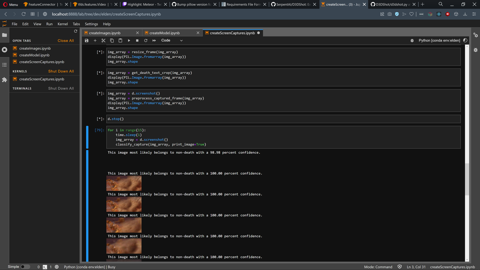

In [19]:
with D() as d:
    p = PIL.Image.fromarray(d.screenshot()).resize(frame_size)
p

Only 1 instance of D3DShot is allowed per process! Returning the existing instance...


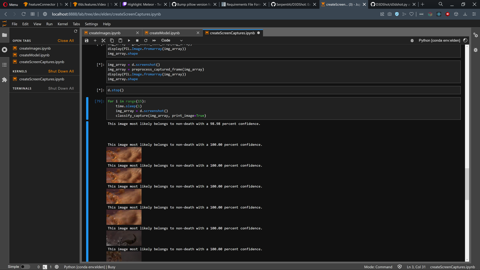

In [20]:
d = d3dshot.create(capture_output="numpy")
display(PIL.Image.fromarray(d.screenshot()).resize(frame_size))

This image most likely belongs to non-death with a 96.07 percent confidence.


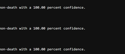

('non-death', 0.9607306)

In [21]:
img_array = d.screenshot()
classify_capture(img_array, True)

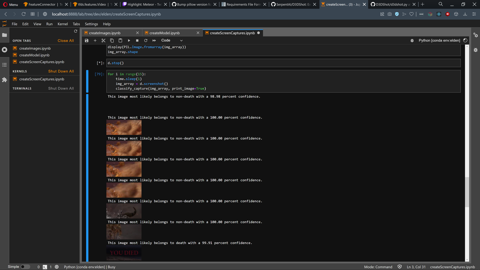

(270, 480, 3)

In [22]:
img_array = resize_frame(img_array)
display(PIL.Image.fromarray(img_array))
img_array.shape

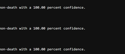

(54, 125, 3)

In [23]:
img_array = get_death_text_crop(img_array)
display(PIL.Image.fromarray(img_array))
img_array.shape

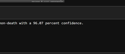

(54, 125, 3)

In [24]:
img_array = d.screenshot()
img_array = preprocess_captured_frame(img_array)
display(PIL.Image.fromarray(img_array))
img_array.shape

In [25]:
d.stop()

False

This image most likely belongs to non-death with a 100.00 percent confidence.


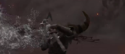

This image most likely belongs to non-death with a 100.00 percent confidence.


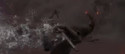

This image most likely belongs to non-death with a 100.00 percent confidence.


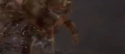

This image most likely belongs to death with a 99.96 percent confidence.


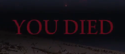

This image most likely belongs to death with a 98.58 percent confidence.


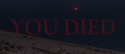

This image most likely belongs to non-death with a 99.97 percent confidence.


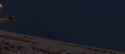

This image most likely belongs to non-death with a 100.00 percent confidence.


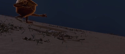

This image most likely belongs to non-death with a 99.98 percent confidence.


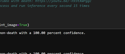

This image most likely belongs to non-death with a 99.98 percent confidence.


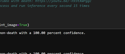

This image most likely belongs to non-death with a 99.98 percent confidence.


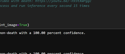

This image most likely belongs to non-death with a 99.98 percent confidence.


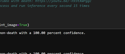

This image most likely belongs to non-death with a 89.20 percent confidence.


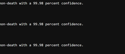

This image most likely belongs to non-death with a 89.20 percent confidence.


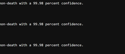

This image most likely belongs to non-death with a 89.20 percent confidence.


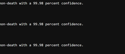

This image most likely belongs to non-death with a 89.20 percent confidence.


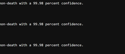

In [28]:
# Test by tabbing into fullscreen video with death: https://youtu.be/-n93tXWPggc
# Will capture a screenshot, preprocess and run inference every second 15 times
for i in range(15):
    time.sleep(1)
    img_array = d.screenshot()
    classify_capture(img_array, print_image=True)